In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=fcf582924c21b4f191e1fc3f5fa6e8f03b59d7f087a75ceca4fb3ac7162666c4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean
from pyspark.sql.types import FloatType

spark = SparkSession.builder \
    .appName("Amazon Bestselling Books Analysis") \
    .getOrCreate()


Прочитати CSV файл

In [ ]:
df = spark.read.csv("bestsellers with categories.csv", header=True, inferSchema=True)


Вивід схеми даних

In [ ]:
print("Схема даних:")
df.printSchema()

Схема даних:
root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)



Вивести назви стовпців і типи даних за допомогою dtypes

In [ ]:
df.dtypes

[('Name', 'string'),
 ('Author', 'string'),
 ('User Rating', 'double'),
 ('Reviews', 'int'),
 ('Price', 'int'),
 ('Year', 'int'),
 ('Genre', 'string')]

Перші 5 рядків

In [ ]:
df.head(5)

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction'),
 Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating=4.6, Reviews=2052, Price=22, Year=2011, Genre='Fiction'),
 Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating=4.7, Reviews=18979, Price=15, Year=2018, Genre='Non Fiction'),
 Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating=4.7, Reviews=21424, Price=6, Year=2017, Genre='Fiction'),
 Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating=4.8, Reviews=7665, Price=12, Year=2019, Genre='Non Fiction')]

Перший рядок (first)

In [ ]:
df.first()

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction')

Опис датасету за допомогою describe()

In [ ]:
df.describe().show()

+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|summary|                Name|          Author|        User Rating|           Reviews|             Price|              Year|      Genre|
+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|  count|                 550|             550|                550|               550|               550|               550|        550|
|   mean|                NULL|            NULL|  4.618363636363641|11953.281818181818|              13.1|            2014.0|       NULL|
| stddev|                NULL|            NULL|0.22698036502519656|11731.132017431892|10.842261978422364|3.1651563841692782|       NULL|
|    min|"The Plant Parado...|Abraham Verghese|                3.3|                37|                 0|              2009|    Fiction|
|    max|You Are a Badass:...|    Zhi Gan

 список стовпців за допомогою columns()

In [ ]:
df.columns

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']

 загальна кількість рядків даних за допомогою count()

In [ ]:
df.count()

550

Перевірте, чи у всіх рядків вистачає даних. Якщо є пропуски, замінить їх на NaN, потім тип даних на числовий.

In [ ]:
for column in df.columns:
    df = df.withColumn(column, when(col(column) == '', None).otherwise(col(column)))

Замініть комірки з пропущеними значенями на середні за стовпцем. І тип даних на float.
Про скільки книг зберігає дані датасет?  :

In [ ]:
from pyspark.sql.types import FloatType

for column in df.columns:
    if df.schema[column].dataType != "string":
        df = df.withColumn(column, df[column].cast(FloatType()))
print(df.count)

<bound method DataFrame.count of DataFrame[Name: float, Author: float, User Rating: float, Reviews: float, Price: float, Year: float, Genre: float]>


Змініть назви всіх колонок: назва з маленької букви, без пробілів через підкреслення.

In [ ]:
df = df.toDF(*['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre'])

df.columns = ['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre']

Знайдіть автора з найвищим рейтингом.




In [ ]:
max_rating_author = df.orderBy(col("User Rating").desc()).select("author").first()[0]
print("Автор з найвищим рейтингом:", max_rating_author)


Автор з найвищим рейтингом: Bill Martin Jr.


Знайдіть автора з найнижчим рейтингом.

In [ ]:
min_rating_author = df.orderBy(col("User Rating").asc()).select("author").first()[0]
print("Автор з найнижчим рейтингом:", min_rating_author)

Автор з найнижчим рейтингом: J.K. Rowling


Знайдіть автора, що має найбільшу кількіть рецензій.

In [ ]:
most_reviews_author = df.orderBy(col("Reviews").desc()).select("author").first()[0]
print("Автор з найбільшою кількістю рецензій:", most_reviews_author)


Автор з найбільшою кількістю рецензій: Delia Owens


Побудуйте гістограму рейтингу 10 найкращих книг (відібрати книги з найбільшим рейтингом).

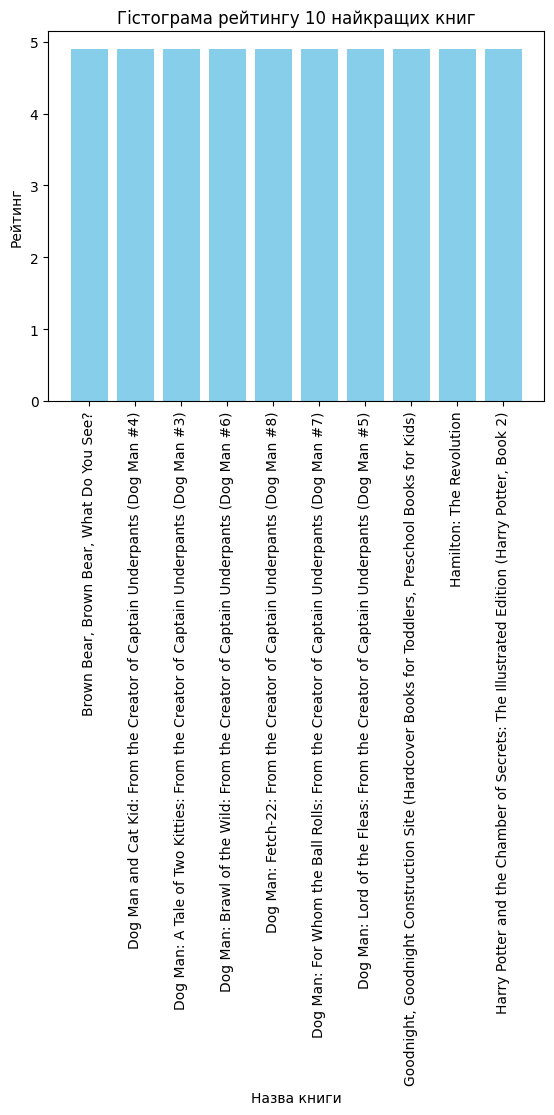

In [ ]:
import matplotlib.pyplot as plt

top_10_books = df.orderBy(col("User Rating").desc(), col("Name")).limit(13).toPandas()

plt.bar(top_10_books['Name'], top_10_books['User Rating'], color='skyblue')

plt.title('Гістограма рейтингу 10 найкращих книг')
plt.xlabel('Назва книги')
plt.ylabel('Рейтинг')
plt.xticks(rotation=90)

plt.show()


Побудуйте матрицю кореляції для стовпчиків 'user_rating', 'reviews', 'price'.




In [ ]:
correlation_matrix = df.select('User Rating', 'reviews', 'price').toPandas().corr()

print("Матриця кореляції:")
print(correlation_matrix)


Матриця кореляції:
             User Rating   reviews     price
User Rating     1.000000 -0.001729 -0.133086
reviews        -0.001729  1.000000 -0.109182
price          -0.133086 -0.109182  1.000000
